# Welcome to Colorful Flavor!
This is the first part of the **MtG Classy Flavor** project. In this notebook, our goal is to use text on a **Magic: The Gathering** card to identify which of the five different colors a card belongs to. This is similar to *sentiment analysis*, where one classifies text as positive, negative, or neutral. However card categories could be considered a bit more complex. The five colors of **Magic** cards have distinct *flavors*. For example, Green cards often depict forests, druids, and wild beasts; while Red cards might depict mountains, goblins, and fire-breathing dragons. Can we train a model to find these differences in the cards?

## Get Card Data from Scryfall using the Scryfall API
[Scryfall](https://scryfall.com/) is a powerful database and search engine for Magic: The Gathering cards. 
We will use their API to download the card data as a JSON file. We then convert the data to a pandas dataframe and isolate unique instances of flavor text.

API reference:
https://scryfall.com/docs/api \
https://scryfall.com/docs/api/bulk-data

In [1]:
import requests,time,os
import numpy as np
import pandas as pd
import CF_standard_functions as cf# Custom functions
import pickle as pkl

First we query Scryfall to find the URI of the most up-to-date batch of card data. We want the address of the 'default_cards' dataset, which contains all unique prints of all cards. Once we have this address, we use it to download the raw card data. We then save the data locally.\ 
There are new Magic cards printed approximately every month. To ensure we have the latest data, we will make a new API call to Scryfall if our local data is more than 24 hours old.  

In [3]:
# Set these directories to determine where to save/load the data from:
filename = 'CardData.pkl'
# Directory for getting data from Scryfall:
sf_bulk_url = "https://api.scryfall.com/bulk-data"

if (os.path.isfile('CardData.pkl')) and (cf.file_age_in_hours('CardData.pkl') < 24):
    print('Loading card data from local file...')
    with open(savepath+filename,'rb') as datafile:
        data = pkl.load(datafile)
    print('Done!')
else:
    print('Downloading data from Scryfall...')
    sf_response = requests.get(sf_bulk_url).json()
    download_dict = [d for d in sf_response['data'] if d['type'] == 'default_cards'][0]
    data_size = np.round(download_dict['size'] / 1e6,1)
    print(f"Downloading {data_size} MB of card data...")
    card_data_raw = requests.get(download_dict['download_uri']).json()
    print("Download complete!")
    # Convert to dataframe and remove cards that aren't in English:
    data = pd.DataFrame(card_data_raw)
    data = data.drop(data.index[data['lang']!='en'])
    print("Saving data to local file...")
    with open(filename,'wb') as datafile:
        pkl.dump(data,datafile)
    print('Done!')
nCards = data.shape[0]
print(f"{nCards} cards in data set")

Download complete!
Saving data to local file...
Done!
102292 cards in data set


## Cleaning and organizing our data

In our data set we have over 100,000 cards! However, there are many cards that are *reprints* - cards that have been printed multiple times over the years with identical (or near-identical) text. There are also subsets of cards that are sometimes termed "funny" - these are cards that were printed mostly as jokes and that have little to do with the main game. We will ignore these in our analyses. \
What we want to analyze in this notebook is **flavor text**: text at the bottom of a card that contains no rules or gameplay information, but that tell short stories or otherwise explain the world and story of Magic. Many cards don't have flavor text, so we will remove these from our dataset as well. This reduces our dataset to a much more managable 18,000 cards 

In [6]:
data = data.drop(data.index[data['set_type'] == 'funny'])
data = data.drop(data.index[data['flavor_text'].isnull()])
data = data.drop_duplicates(subset = 'name')

# Convert flavor text to lower case.
data['flavor_text'] = data.flavor_text.apply(lambda x : x.lower())
nCards = data.shape[0]
print(f"{nCards} unique cards in data set with flavor text")

18057 unique cards in data set with flavor text


### Organize cards by color
Here we will classify flavor text by color. For convenience, we will make a new dataframe subsetting only the name, flavortext, and color of monocolored cards (i.e. excluding cards that have no color or are multiple colors).\
To make separating cards by colors easier, we add a Boolean variable to the dataframe for each color. We also add a Boolean for whether or not a card is monocolored. \
Finally, sort our cards in traditional **WUBRG** order (**W**hite, Bl**u**E, **B**lack, **R**ed, **G**reen) by setting the _colors_ variable to a categorical value.


In [10]:
for c in ['W','U','B','R','G']:
    tf = data.colors.apply(lambda x : np.shape(x) != (0,) and np.any(np.isin(x,c)))
    data['is_'+c] = tf

data['is_monocolor'] = np.sum(data.loc[:][['is_W','is_U','is_B','is_R','is_G']],axis=1) == 1

data_monocolor = data.loc[data.is_monocolor][['name','colors','flavor_text']].copy()
data_monocolor['colors'] = data_monocolor.colors.apply(lambda x: ''.join(x)) # Convert from list to string

data_monocolor['colors'] = pd.Categorical(data_monocolor['colors'],ordered=True)
data_monocolor['colors'] = data_monocolor['colors'].cat.reorder_categories(['W','U','B','R','G'])
data_monocolor.sort_values('colors',ascending=True,inplace=True)
data_monocolor.sample(5)

,name,colors,flavor_text
59448,Jace's Sentinel,U,"""we drove the sun empire out of the forest lon..."
58036,Swirling Torrent,U,"""oops!""\n—grupgrup, sluiceway technician"
54308,Unstable Shapeshifter,U,"""in a world of untruths, the living lie rules...."
35515,Illustrious Historian,R,the most distinguished lorehold professors are...
34321,Enormous Baloth,G,"its diet consists of fruits, plants, small woo..."


### Prepare data for classification

We will be classifying our cards with **Scikit-Learn**. Sckit-Learn needs numerical categories, not strings. So we will map each color string to a number:

In [12]:
label_map = {'W':0,
             'U':1,
             'B':2,
             'R':3,
             'G':4}
data_monocolor['label'] = data_monocolor['colors'].map(label_map)
data_monocolor.sample(5)

,name,colors,flavor_text,label
23828,Vampire Champion,B,"""these pirates must answer for their ancestors...",2
38068,Sun Sentinel,W,just as the sun rises at dawn and the days len...,0
23000,Chaos Maw,R,the food chain doesn't end at sandwurms.,3
3294,Shepherd of the Lost,W,"""should you fall in the wilds, lift your voice...",0
55226,Grim Javelineer,B,kheti lost everything to the eternals and the ...,2


### Split data into train and test sets

Using ScikitLearn's train_test_split, split our cards into a training set (75%) and a test set (25%). 

In [15]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monocolor['flavor_text'], data_monocolor['label'], test_size=0.25, random_state=42)

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')


Training set consists of 10473 cards.
Test set consists of 3491 cards.


## Design our Model!
First we _tokenize_ the words in flavor text and convert them to numeric values, ignoring terms that are extremely common and those that only appear 3 or fewer times in the training set. \
Then, we fit a Linear Support Vector Classifier on our training data. \
These two steps can be wrapped up together in a ScikitLearn Pipeline object.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(min_df = 3,max_df=0.95)
my_linSVC = LinearSVC(C=1)
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',my_linSVC)])

pipe = pipe.fit(flavor_train,label_train)

#### Measure model accuracy on test data

In [20]:
label_predict = pipe.predict(flavor_test)
performance = sum(label_predict == label_test) / len(label_test) * 100
print(f"Classifier accuracy is {np.round(performance,1)}%")

Classifier accuracy is 45.5%


#### Visualize model performance with a confusion matrix

              precision    recall  f1-score   support

           W       0.44      0.43      0.44       722
           U       0.45      0.44      0.44       700
           B       0.44      0.48      0.46       678
           R       0.49      0.45      0.47       743
           G       0.46      0.47      0.47       648

    accuracy                           0.46      3491
   macro avg       0.46      0.46      0.46      3491
weighted avg       0.46      0.46      0.46      3491



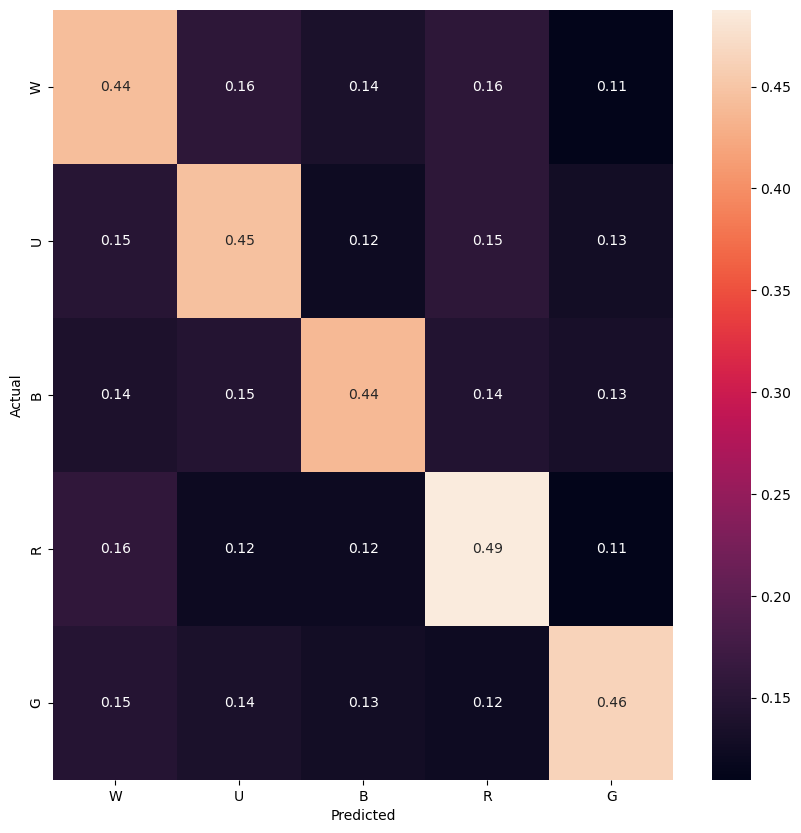

In [25]:
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt

print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in label_map]))

cm = metrics.confusion_matrix(label_predict, label_test,normalize='true',
                              labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in label_map],yticklabels=[str(i) for i in label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


**Not too shabby!** \
Our classifier gets the correct color around 45% the time. This might not seem very accurate, but remember that there are five colors, so we would only have about a 20% hit rate by randomly guessing. 

We can also write our own flavor text and see what color our model thinks it belongs to!

In [9]:
new_flavor_text = ['Goblins sure do smell bad',
              'Your spell was a mistake and now it is gone',
              'Trees are the most beautiful thing',
              'Death cannot stop the wicked',
              'The angelic choir sings loftily over the clouds',
              '"Some like it hot" -Chandra Nalaar']

new_color_predictions = pipe.predict(new_flavor_text)
# Reverse-lookup color mapping    
for txt,col in zip(new_flavor_text,new_color_predictions):
    print(f"{txt} --> {[str(i) for i in label_map][col]}")

Goblins sure do smell bad --> R
Your spell was a mistake and now it is gone --> U
Trees are the most beautiful thing --> G
Death cannot stop the wicked --> B
The angelic choir sings loftily over the clouds --> U
"Some like it hot" -Chandra Nalaar --> R


From these plots, it looks like the C parameter of the LinearSVC is the most important parameter to adjust, though differences in how we vectorize the text can help a bit.\
_max_cf_ has little effect, and a higher _max_cf_ value means we are removing more words from our lexicon, so let's leave that at 0.95 to keep more words in our model without hurting performance.

**Retrain the model with these new parameters**

## Investigate the Model
Now that we have an optimized model, lets look into what types of text the model does well or poorly on. \
For now, we will only look at cards in our test set (to avoid re-running the model several times). 

One likely cause of misclassification is from cards with very short flavor text. We can check this by plotting the portion of correct classifications as a function of flavor text length.

First, let's look at the distribution of the number of words in flavor text, binning by 5 words:

[Text(0, 0.5, 'Count of Cards'),
 Text(0.5, 0, 'Number of Words in Flavor Text')]

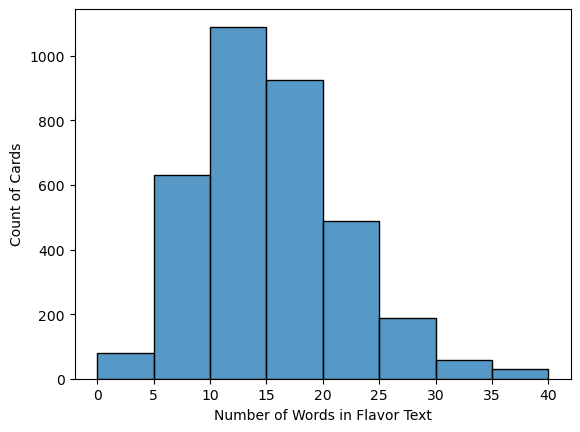

In [30]:
# Put test data into a dataframe for easier plotting and indexing
test_df = pd.DataFrame(data={'flavor_text':flavor_test,'label':label_test})
test_df['word_count'] = test_df.flavor_text.apply(lambda x : len(x.split()))
test_df['predicted'] = pipe.predict(test_df['flavor_text'])
test_df['correct'] = np.equal(test_df['label'],test_df['predicted'])
test_df = pd.concat([test_df,data_monocolor['name']],axis=1,join='inner')
test_df = test_df[['name','flavor_text','word_count','label','predicted','correct']]

bins = np.arange(0,45,5)
ax = plt.axes()
sns.histplot(data=test_df,x='word_count',bins=bins,ax=ax)
ax.set(ylabel='Count of Cards',xlabel='Number of Words in Flavor Text')

Now for each bin, find the proportion of cards in that bin that are correctly classified:

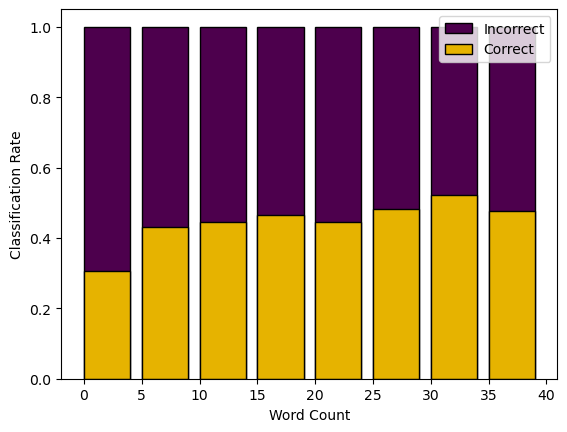

In [32]:
# Preallocate arrays
counts_correct = np.zeros(len(bins)-1)
counts_all =   np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sub_data = test_df[(test_df.word_count > bins[i]) & (test_df.word_count <= bins[i+1])]
    counts_correct[i] = sum(sub_data.correct)
    counts_all[i] = sub_data.shape[0]
plot_bin_width = (bins[1]-bins[0])*0.8
    
hit_rate = counts_correct / counts_all
bar_x = [np.mean([y,z]) for y,z in zip(bins[:-1],bins[1:])]
bar_df = pd.DataFrame({'Bin':bins[:-1],'Correct_Rate':hit_rate,'Incorrect_Rate':1-np.array(hit_rate)})
miss_bar = plt.bar(bins[:-1],np.ones(np.size(hit_rate)),align='edge',width=plot_bin_width,
                   edgecolor='k',color=[0.3,0,0.3])
hit_bar = plt.bar(bins[:-1],hit_rate,align='edge',width=plot_bin_width,
                  edgecolor='k',color=[0.9,0.7,0])
plt.ylabel('Classification Rate')
plt.xlabel('Word Count')
miss_bar.set_label('Incorrect')
hit_bar.set_label('Correct')
plt.legend()

It looks like there might be a weak relationship between word count and classifier accuracy. We can test this hypothesis with a simple logistic regression:

In [34]:
from scipy.special import expit # Logistic sigmoid function
import statsmodels.api as sm
from scipy import stats

X = np.array(test_df['word_count'])
y = test_df['correct']
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.685582
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                 3491
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                0.001484
Time:                        22:38:55   Log-Likelihood:                -2393.4
converged:                       True   LL-Null:                       -2396.9
Covariance Type:            nonrobust   LLR p-value:                  0.007649
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4402      0.086     -5.107      0.000      -0.609      -0.271
x1             0.0141      0.

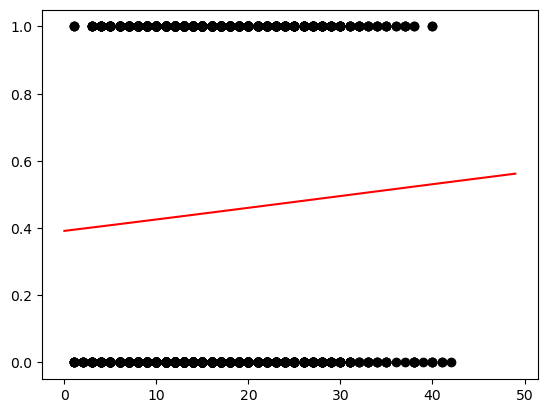

In [35]:
X_predict = np.arange(0,50)
X_predict = sm.add_constant(X_predict)
pred = model.predict(X_predict)
plt.plot(X_predict[:,1],pred,color='r')
plt.scatter(test_df['word_count'],test_df['correct'],color='k')

This model is significant, but only explains a tiny fraction of the variance in the data (low R<sup>2</sup>). So our classifier performs only marginally better on longer pieces of text.

In [38]:
label_map_inv = {v: k for k, v in label_map.items()}
test_df['label_color'] = test_df['label'].map(label_map_inv)
test_df['predicted_color'] = test_df['predicted'].map(label_map_inv)


pd.set_option('display.max_colwidth', None)
test_df[test_df.correct == False]

,name,flavor_text,word_count,label,predicted,correct,label_color,predicted_color
88228,Vampiric Fury,many peasants secretly admire vampires' glamour and elegance—until they witness a moment of pure bloodlust.,15,3,0,False,R,W
2952,Terrifying Presence,"elmut had slaughtered vampires, slain werewolves, and destroyed hordes of zombies. sadly, he never got over his fear of spiders.",20,4,3,False,G,R
32362,Smelt-Ward Ignus,"""come in, yes? is warm!""",5,3,2,False,R,B
6697,Nurturing Pixie,"""count yourself lucky i came upon you. this is not a world of second chances.""",15,0,3,False,W,R
25311,Journey for the Elixir,"""as my hands touched it, i realized that i had not found it—it had been leading me here.""",18,4,0,False,G,W
...,...,...,...,...,...,...,...,...
84772,Beasts of Bogardan,bogardan is a land as volatile as the creatures who live there.,12,3,1,False,R,U
61494,Toxin Sliver,it doesn't need to use its venom—it just needs you to know it can.,14,2,3,False,B,R
72632,Facet Reader,"""every flaw in the crystal represents a moment where our strategy might go wrong.""",14,1,0,False,U,W
13677,Choose Your Weapon,"""move it, varis, or i'll pick one for you!""\n—ellywick tumblestrum",11,4,3,False,G,R
